# Seminar 2. Networks of spiking neurons
* Synapses in Brian2 simulator 
* Models of synaptic transmission
* Visualizing neural population
* Adding noise
* Synchronization
* Connectivity patterns: full, random, layered, recurrent
* Network inputs and outputs
https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html

### Synapses in Brian2

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


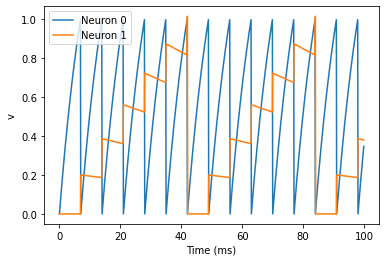

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
from brian2 import ms,mvolt

b2.start_scope() # clear the Brian scope

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = b2.Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

#S_inh = b2.Synapses(G, G, on_pre='v_post -= 0.3')
#S_inh.connect(i=1, j=0)

M = b2.StateMonitor(G, 'v', record=True)

b2.run(100*ms)

plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.plot(M.t/ms, M.v[1], label='Neuron 1')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();

### Synaptic weights

WARNING    C:\Users\nbazs\Anaconda3\envs\sirius\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
 [py.warnings]
WARNING    C:\Users\nbazs\Anaconda3\envs\sirius\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
 [py.warnings]


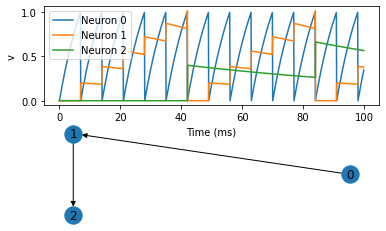

In [2]:
import numpy as np
import networkx as nx

b2.start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = b2.NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = b2.Synapses(G, G, 'w : 1', on_pre='v_post += w')

S.connect(i=[0,1], j=[1, 2])#create 0->1 and 1->2 connections
#S.w = '0.3' # constant
#S.w = 'j*0.2' # j is the target index
S.w = '(i+1)*0.2' # i is the source index

M = b2.StateMonitor(G, 'v', record=True)

b2.run(100*ms)

fig, (ax_V, ax_Net) = plt.subplots(2,1)
plt.subplot(ax_V)
plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.plot(M.t/ms, M.v[1], label='Neuron 1')
plt.plot(M.t/ms, M.v[2], label='Neuron 2')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();

plt.subplot(ax_Net)
elist = [(0,1),(1,2)]
G = nx.DiGraph(elist)
nx.draw_circular(G, with_labels=True)

### Neural populations
Here we do:
* create a population of N=100 neurons
* create random connectivity
* visualize their activity

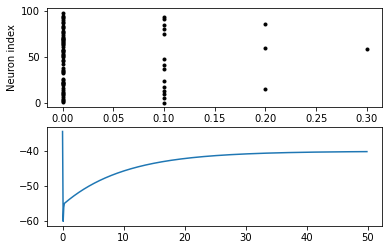

In [88]:
b2.start_scope()
num = 100
R = 10. * b2.Mohm # membrane resistance 
tau = 10*ms # membrane time scale
v_rest = -50 * mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * mvolt # threshold
v_reset = -60 * mvolt # reset potential
I = 0 * b2.namp
eqs ='''
     dv/dt=(v_rest-v)/tau + R*I/tau: volt
     '''
G = b2.NeuronGroup(num,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='exact')
G.v='v_reset*rand()'

S = b2.Synapses(G, G, 'w : volt', on_pre='v_post += w')
S.connect(p=0.2)#create 0->1 and 1->2 connections
S.w = '0.95*mvolt' # constant
#S.w = 'j*0.2' # j is the target index
#S.w = '(i+1)*0.2' # i is the source index

v_mon = b2.StateMonitor(G, 'v', record=range(0,10))
spikemon = b2.SpikeMonitor(G)

T = 50 * ms
b2.run(T)

fig, (ax_spikes, ax_V) = plt.subplots(2,1)
plt.subplot(ax_spikes)
plt.plot(spikemon.t/ms, spikemon.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index');

plt.subplot(ax_V)
#plt.plot(spikemon.t/ms, v_mon.v[0][0:len(spikemon.t)]/mvolt)
plt.plot(v_mon.t/ms, v_mon.v[1]/mvolt)
#plt.plot(spikemon.t/ms, v_mon.v[2]/mvolt)


### Connectivity pattern
* layered
* small world
* recurrent

### Interacting populations
Brunel model
https://neuronaldynamics.epfl.ch/online/Ch13.S4.html
* Create three neuronal populations
* Create connections
* Observe and measure synchrony 
* Tune parameters to obtain synchrony pattern

<spikemonitor_1.count: array([4, 4])>
[10 10]


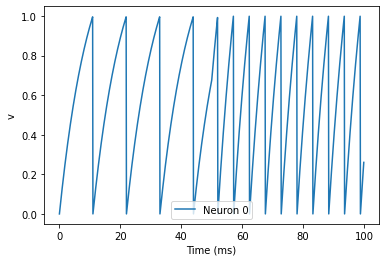

In [17]:
# Test vector input to neuron
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
from brian2 import ms,mvolt
import numpy as np

b2.start_scope() # clear the Brian scope

eqs = '''
dv/dt = (I-v)/tau + inp/tau : 1
I : 1
tau : second
inp : 1
'''
w = np.array([0.5,-0.5])
obs = np.array([4,1])

G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = 0
G.tau = 10*ms
G.inp = w@obs

M = b2.StateMonitor(G, 'v', record=True)
SM = b2.SpikeMonitor(G)

b2.run(50*ms)
count_prev = np.array(SM.count)
print(SM.count)
obs[0] = 6
G.inp = w@obs
b2.run(50*ms)
new_count = SM.count - count_prev
print(new_count)

plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();
#print(SM.count)